In [83]:
import os, shutil
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

folder = "../archive/gridsearch/"
features = ["Budget", "Noise", "Alpha", "C", "N-Steps", "LR", "Interactions", "N-Hidden", "Regularization", "Gamma", "Reward-Noise", "Linear"]
target = ["Regret", "Std"]

In [84]:
def iterate_files():
    for f in os.listdir(folder):
        run_folder = os.path.join(folder, f)
        result_file = os.path.join(run_folder, "result.txt")
        if os.path.exists(result_file):
            yield result_file
        else:
            print(f"WARNING: no result file in {run_folder}")

In [85]:
def fix_attribute(name, old_value, new_value):
    for result_file in iterate_files():
        content_lines = []
        with open(result_file) as r_file:
            for line in r_file.readlines():
                if line.startswith(f"{name}: {old_value}"):
                    content_lines.append(f"{name}: {new_value}\n")
                else:
                    content_lines.append(f"{line}")
        os.remove(result_file)
        with open(result_file, "w") as f:
            f.writelines(content_lines)

# fix_attribute("N-Hidden", 10, 24)

In [86]:
def add_attribute(name, default_value):
    for result_file in iterate_files():
        attr_present = False
        content_lines = []
        with open(result_file) as r_file:
            for line in r_file.readlines():
                if line.startswith(name):
                    attr_present = True
                content_lines.append(f"{line}")
            if not attr_present:
                content_lines = [f"{name}: {default_value}\n"] + content_lines
        os.remove(result_file)
        with open(result_file, "w") as f:
            f.writelines(content_lines)

# add_attribute("Linear", 1)

In [87]:
result_contents = dict()
for f in features + target:
    result_contents[f] = list()

for result_file in iterate_files():
    with open(result_file) as r_file:
        for line in r_file.readlines():
            if ":" in line:
                parts = line.split(":")
                if parts[0] in features:
                    result_contents[parts[0]].append(float(parts[1]))
                elif parts[0] == target[0]:
                    t_parts = parts[1].split(' +- ')
                    result_contents[target[0]].append(float(t_parts[0]))
                    result_contents[target[1]].append(float(t_parts[1]))

In [88]:
df = pd.DataFrame.from_dict(result_contents)
df

,Budget,Noise,Alpha,C,N-Steps,LR,Interactions,N-Hidden,Regularization,Gamma,Reward-Noise,Linear,Regret,Std
0,800.0,1.0,0.6,500.0,2.0,0.01,250000.0,24.0,0.00100,0.0,1.0,1.0,0.0900,0.0024
1,800.0,1.0,0.6,500.0,1.0,0.01,250000.0,24.0,0.00100,0.0,1.0,1.0,0.0598,0.0014
2,1600.0,1.0,0.6,500.0,1.0,0.01,250000.0,24.0,0.00010,0.0,1.0,1.0,0.0756,0.0038
3,800.0,1.0,0.6,500.0,1.0,0.01,100000.0,24.0,0.00001,0.0,1.0,1.0,0.0424,0.0025
4,800.0,1.0,0.6,500.0,2.0,0.01,100000.0,24.0,0.01000,0.0,1.0,1.0,0.1278,0.0064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,1600.0,1.0,0.6,500.0,2.0,0.01,250000.0,24.0,0.00100,0.0,1.0,1.0,0.1960,0.0035
59,800.0,1.0,0.6,500.0,1.0,0.01,100000.0,24.0,0.00010,0.0,1.0,1.0,0.0431,0.0053
60,1600.0,1.0,0.6,500.0,2.0,0.01,100000.0,24.0,0.00100,0.0,1.0,1.0,0.2126,0.0050
61,800.0,1.0,0.6,500.0,1.0,0.01,250000.0,24.0,0.00001,0.0,1.0,1.0,0.0060,0.0025


In [89]:
def plot_boxplot(col_name, df):
    labels = df[col_name].unique()
    labels = sorted(labels)
    #print(labels)
    result = dict()
    for v in labels:
        result[v] = list()
    for index, row in df.iterrows():
        result[row[col_name]].append(row["Regret"])
    values = list()
    print("Values")
    for k, v in result.items():
        values.append(v)
        print("%s: %1.4f +- %1.4f"%(k, np.mean(v), np.std(v)))

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.boxplot(values)
    ax.set_xlabel(col_name)
    ax.set_ylabel("Regret")
    plt.setp(ax, xticks=range(1, len(labels)+1), xticklabels=labels)
    plt.show()
    plt.clf()

In [90]:
def plot_heatmap(col_name, row_name, df):
    columns = df[col_name].unique()
    columns = sorted(columns)
    columns = [str(c) for c in columns]
    rows = df[row_name].unique()
    rows = sorted(rows)
    rows = [str(r) for r in rows]

    heatmap_df = pd.DataFrame(columns=columns, index=rows, dtype="float")
    divisors_df = heatmap_df.copy(deep=True)
    for rowIndex, row in divisors_df.iterrows():
        for columnIndex, value in row.items():
            heatmap_df.at[rowIndex, columnIndex] = 0.0
            divisors_df.at[rowIndex, columnIndex] = 0.0

    for index, row in df.iterrows():
        heatmap_df.at[str(row[row_name]), str(row[col_name])] += float(row["Regret"])
        divisors_df.at[str(row[row_name]), str(row[col_name])] += 1.0

    for rowIndex, row in heatmap_df.iterrows():
        for columnIndex, value in row.items():
            if divisors_df.at[rowIndex, columnIndex] == 0:
                heatmap_df.at[rowIndex, columnIndex] = np.NAN
            else:
                heatmap_df.at[rowIndex, columnIndex] /= divisors_df.at[rowIndex, columnIndex]

    hm = sns.heatmap(heatmap_df, annot=True)
    hm.set(xlabel=col_name, ylabel=row_name)
    plt.show()

## How many N-Steps do we need?

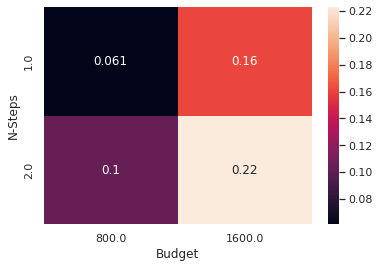

Values
1.0: 0.1108 +- 0.0744
2.0: 0.1617 +- 0.0666


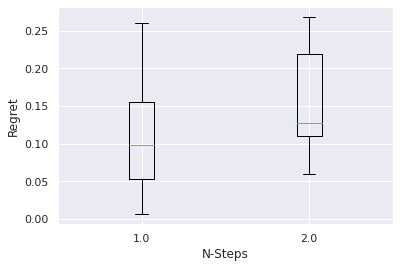

<Figure size 432x288 with 0 Axes>

In [91]:
plot_heatmap("Budget", "N-Steps", df)
plot_boxplot("N-Steps", df)

## How much noise can be tolerated?

Values
1.0: 0.1358 +- 0.0751


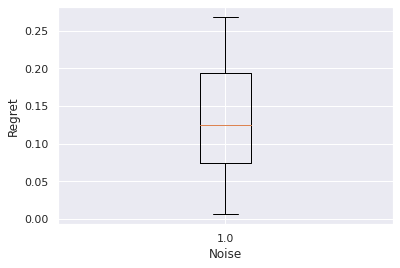

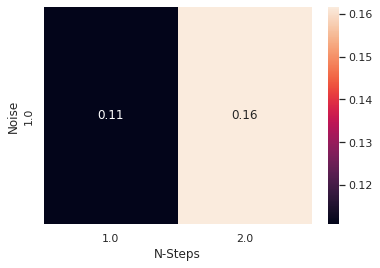

In [92]:
plot_boxplot("Noise", df)
plot_heatmap("N-Steps", "Noise", df)

### How Many Interactions per Budget?

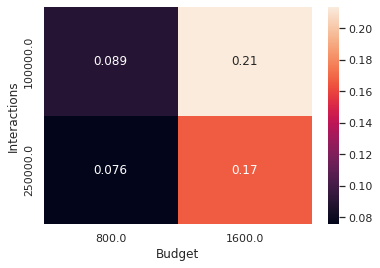

In [93]:
plot_heatmap("Budget", "Interactions", df)

### Size of the Linear Agent

Values
24.0: 0.1358 +- 0.0751


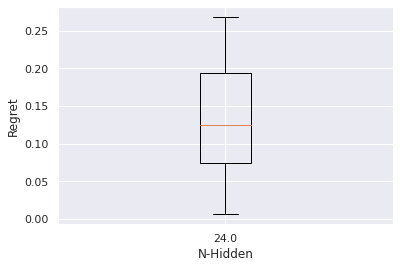

<Figure size 432x288 with 0 Axes>

In [94]:
plot_boxplot("N-Hidden", df)

### Best Model for 1600 Budget

In [95]:
df[df["Budget"]==1600]

,Budget,Noise,Alpha,C,N-Steps,LR,Interactions,N-Hidden,Regularization,Gamma,Reward-Noise,Linear,Regret,Std
2,1600.0,1.0,0.6,500.0,1.0,0.01,250000.0,24.0,0.00010,0.0,1.0,1.0,0.0756,0.0038
5,1600.0,1.0,0.6,500.0,1.0,0.01,100000.0,24.0,0.01000,0.0,1.0,1.0,0.2495,0.0049
6,1600.0,1.0,0.6,500.0,1.0,0.01,100000.0,24.0,0.00100,0.0,1.0,1.0,0.1921,0.0096
10,1600.0,1.0,0.6,500.0,2.0,0.01,100000.0,24.0,0.00001,0.0,1.0,1.0,0.2687,0.0013
11,1600.0,1.0,0.6,500.0,1.0,0.01,250000.0,24.0,0.01000,0.0,1.0,1.0,0.2468,0.0078
12,1600.0,1.0,0.6,500.0,2.0,0.01,250000.0,24.0,0.01000,0.0,1.0,1.0,0.2566,0.0030
13,1600.0,1.0,0.6,500.0,1.0,0.01,100000.0,24.0,0.00100,0.0,1.0,1.0,0.1898,0.0136
16,1600.0,1.0,0.6,500.0,1.0,0.01,250000.0,24.0,0.00100,0.0,1.0,1.0,0.1417,0.0021
18,1600.0,1.0,0.6,500.0,2.0,0.01,250000.0,24.0,0.00010,0.0,1.0,1.0,0.1573,0.0096
23,1600.0,1.0,0.6,500.0,2.0,0.01,100000.0,24.0,0.01000,0.0,1.0,1.0,0.2582,0.0152


## Linear Model

In [96]:
X = df.values[:, :-2] # last two columns are target
Y = df.values[:, -2]  # -1: std  -2: mean
res = cross_val_score(LinearRegression(), X, Y, cv=5, scoring="neg_mean_absolute_error")
print(res)

[-0.02681526 -0.02790199 -0.0273024  -0.01849871 -0.023347  ]


In [97]:
model = LinearRegression().fit(X, Y)
budget = 2000
noise = 1.0
alpha = 0.6
c = 500
nsteps = 1
lr = 0.01
interactions = 500000

best = np.inf
x_best = None
for interactions in [2000000, 4000000, 8000000]:
    for nsteps in [1, 2, 3, 5]:
        x = np.array([[budget, noise, alpha, c, nsteps, lr, interactions]])
        y_hat = model.predict(x)
        if y_hat < best:
            best = y_hat
            x_best = x

for_printing = pd.DataFrame(columns=df.columns)
for_printing.loc["best"] = list(x_best[0]) + list(best) + [0]
for_printing

ValueError: X has 7 features, but LinearRegression is expecting 12 features as input.